In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
torch.cuda.set_device(0)

In [10]:
torch.backends.cudnn.benchmark=True

## Data

In [11]:
PATH = Path('/fastai/data/carvana/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'

masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [49]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [13]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz =  128
bs = 64
nw = 16

In [14]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [18]:
x_names =  np.array([str(Path(TRAIN_DN)/o) for o in masks_csv['img']])
y_names =  np.array([str(Path(MASKS_DN)) +f'/{o[:-4]}_mask.png' for o in masks_csv['img']])

In [19]:
val_idxs =  list(range(1008))
((val_x, trn_x), (val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [20]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [22]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y= TfmType.CLASS, aug_tfms=aug_tfms)
datasets =  ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x, val_y), tfms, path=str(PATH))
md = ImageData(str(PATH), datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [23]:
x,y = next(iter(md.trn_dl))

In [24]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

## Simple upsample

We use resnet34 and cut the backbone layers and use that as base.

In [25]:
f = resnet34
cut, lr_cut = model_meta[f]

In [26]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

dice is a metric used by Kaggle, its simialr to jaccard overlap intersect/union

In [28]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [30]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [31]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self, x): return self.features(x)[:,0]

In [32]:
class UpsampleModel():
    def __init__(self, model, name='upsample'):
        self.model, self.name =  model, name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [33]:
m_base = get_base()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 22530835.27it/s]


In [34]:
m = to_gpu(Upsample34(m_base))
models =  UpsampleModel(m)

In [35]:
learn =  ConvLearner(md, models)
learn.opt = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5), dice]

In [36]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.475748   760.266176 0.221134   0.34641   



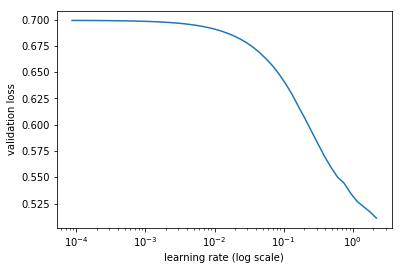

In [37]:
learn.lr_find()
learn.sched.plot()

In [39]:
lr=6e-1
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [40]:
learn.fit(lr, 1, wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.125717   0.053218   0.974871   0.944184  
    1      0.063533   0.044628   0.980396   0.954074        
    2      0.045387   0.037285   0.983264   0.962566        
    3      0.037786   0.034654   0.9845     0.965595        



[0.03465444754276957, 0.9845001602929736, 0.9655946587759351]

In [41]:
learn.save('tmp')

In [42]:
learn.load('tmp')

In [43]:
learn.unfreeze()
learn.bn_freeze(True)

In [44]:
learn.fit(lrs, 1, cycle_len= 4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.032078   0.033873   0.985268   0.966525  
    1      0.031169   0.032812   0.985699   0.967607        
    2      0.030272   0.031982   0.986444   0.968801        
    3      0.029653   0.031693   0.98659    0.969143        



[0.031693155832943465, 0.9865899473901779, 0.9691425533521743]

In [46]:
learn.save('unet/128')

In [47]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

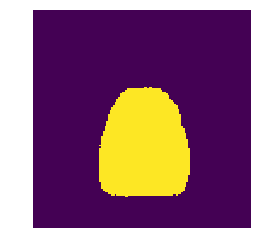

In [50]:
show_img(py[0]>0)

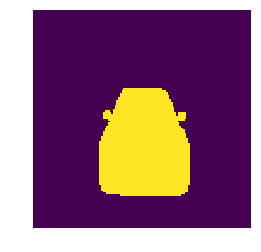

In [51]:
show_img(y[0])

## U-net (ish)

In [52]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [53]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out =  x_out = n_out//2
        self.x_conv = nn.Conv2d(x_in, x_out, 1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p =  self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [57]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
    
    def forward(self, x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
        

In [58]:
class UnetModel():
    def __init__(self, model, name='unet'):
        self.model, self.name = model, name
        
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [59]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [60]:
learn = ConvLearner(md, models)
learn.opt = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5), dice]

In [61]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 

In [62]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [63]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.422714   450.977653 0.21166    0.323885  



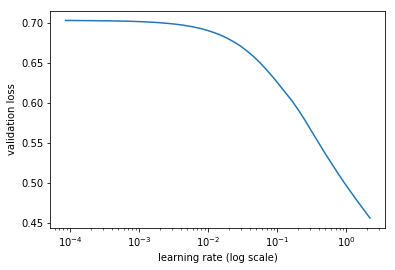

In [64]:
learn.lr_find()
learn.sched.plot()

In [72]:
lr = 4e-2
wd = 1e-7
lrs = np.array([lr/100,lr/10,lr])

In [67]:
learn.fit(lrs, 1, wds=wd, cycle_len=8, use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.0195     0.021274   0.991383   0.979911  
    1      0.019992   0.022007   0.991704   0.97942         
    2      0.019149   0.020688   0.991595   0.980515        
    3      0.018725   0.02088    0.991826   0.980535        
    4      0.018581   0.020799   0.992001   0.980609        
    5      0.018306   0.02032    0.991582   0.980838        
    6      0.017995   0.020281   0.991509   0.980815        
    7      0.017868   0.020088   0.991809   0.981091        



[0.020087896654057125, 0.9918087550571987, 0.9810910073537675]

In [68]:
learn.save('unet/128-urn-tmp')

In [69]:
learn.load('unet/128-urn-tmp')

In [70]:
learn.unfreeze()
learn.bn_freeze(True)

In [73]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.016388   0.019542   0.99222    0.981912  
    1      0.01646    0.019538   0.992218   0.981905        
    2      0.016422   0.019535   0.99221    0.981895        
    3      0.016353   0.019526   0.992186   0.981902        
    4      0.016412   0.019528   0.99219    0.981886        
    5      0.016392   0.019536   0.992249   0.981927        
    6      0.016381   0.019527   0.992229   0.981908        
    7      0.01638    0.019533   0.992241   0.981911        
    8      0.016339   0.019519   0.992217   0.981917        
    9      0.016375   0.019534   0.992242   0.98193         
    10     0.016364   0.019519   0.992214   0.981915        
    11     0.016411   0.01951    0.992212   0.981929        
    12     0.016368   0.019516   0.992225   0.981927        
    13     0.016425   0.01951    0.992213   0.98193         
    14     0.016379   0.019508   0.992217   0.981936        
    15     0.016409   0.01951 

[0.019508680180897787, 0.9922260102771577, 0.9819403347514924]

In [74]:
learn.save('unet/128-urn-0')

In [75]:
learn.load('unet/128-urn-0')

In [76]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

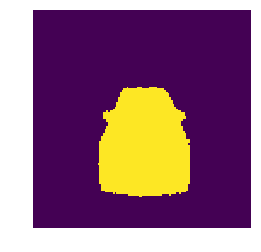

In [77]:
show_img(py[0]>0)

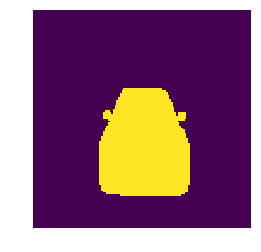

In [78]:
show_img(y[0])

In [79]:
m.close()

## 512x512

In [80]:
sz = 512
bs = 16

In [84]:
tfms =  tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y = TfmType.CLASS, aug_tfms=aug_tfms)
datasets =  ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, path=str(PATH))
md = ImageData(str(PATH), datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [85]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [86]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), dice]

In [87]:
learn.freeze_to(1)

In [88]:
learn.load('unet/128-urn-0')

In [89]:
learn.fit(lr, 1, wds=wd, cycle_len=5, use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.023624   0.024426   0.991417   0.978265  
    1      0.019754   0.019265   0.993183   0.98238           
    2      0.016392   0.015296   0.993507   0.985714          
    3      0.014856   0.0143     0.994375   0.986886          
    4      0.014302   0.013343   0.994625   0.987691          



[0.01334292089773549, 0.9946248001522489, 0.9876907212393624]

In [90]:
learn.save('unet/512-urn-tmp')

In [91]:
learn.unfreeze()
learn.bn_freeze(True)

In [92]:
learn.load('unet/512-urn-tmp')

In [93]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=8, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.229407   0.365339   0.865573   0.621765  
    1      0.039223   0.030076   0.988      0.97242           
    2      0.022198   0.022205   0.991008   0.979895          
    3      0.018431   0.018381   0.992382   0.983013          
    4      0.016908   0.016563   0.993271   0.984724          
    5      0.016044   0.016242   0.993228   0.984974          
    6      0.015538   0.015425   0.993984   0.985834          
    7      0.015358   0.015253   0.993837   0.985942          



[0.015252592456009652, 0.9938374095492892, 0.9859416323994833]

In [94]:
learn.save('unet/512-urn')

In [96]:
learn.load('unet/512-urn')

In [97]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

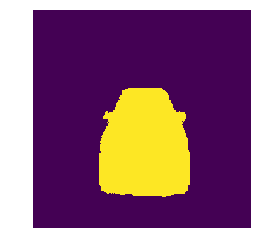

In [98]:
show_img(py[0]>0)

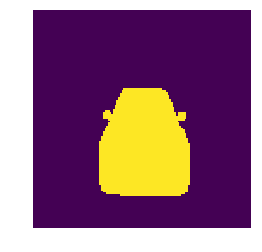

In [99]:
show_img(y[0])

In [100]:
m.close()

## 1024x1024

In [101]:
sz = 1024
bs=4

In [102]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x, val_y), tfms, path=str(PATH))
md = ImageData(str(PATH), datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [103]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models =  UnetModel(m)

In [104]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5), dice]

In [105]:
learn.load('unet/512-urn')

In [106]:
learn.freeze_to(1)

In [107]:
learn.fit(lr, 1, wds=wd, cycle_len=2, use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice                
    0      0.018517   0.021243   0.992865   0.981677  
    1      0.011477   0.01438    0.994534   0.986937            



[0.014380014638253858, 0.9945337734525166, 0.986937482678701]

In [108]:
learn.save('unet/1024-urn-tmp')

In [109]:
learn.load('unet/1024-urn-tmp')

In [110]:
learn.unfreeze()
learn.bn_freeze(True)

In [111]:
lrs = np.array([lr/200, lr/30, lr])

In [112]:
learn.fit(lrs/10,1, wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                
    0      0.011383   0.011608   0.995582   0.989634  
    1      0.010053   0.011046   0.995449   0.989884             
    2      0.009501   0.010738   0.995799   0.990269             
    3      0.009356   0.010664   0.995885   0.990363             



[0.010663899423051921, 0.9958851753719269, 0.9903627858748512]

In [113]:
learn.fit(lrs/10,1,wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.009528   0.010967   0.995805   0.990052  
    1      0.009027   0.010537   0.995932   0.990545             
    2      0.008966   0.010327   0.995891   0.990666             
    3      0.008611   0.010243   0.995991   0.990799             



[0.010242960977530668, 0.9959909575326102, 0.990798545735223]

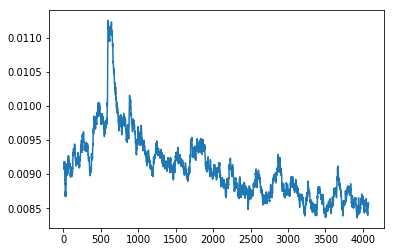

In [114]:
learn.sched.plot_loss()

In [115]:
learn.save('unet/1024-urn')

In [116]:
learn.load('unet/1024-urn')

In [117]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

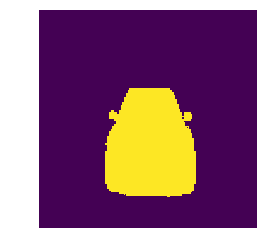

In [118]:
show_img(py[0]>0)

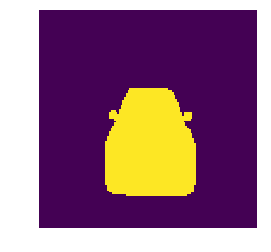

In [119]:
show_img(y[0])